In [1]:
import matplotlib.pyplot as plt
import numpy as np



rng = np.random.default_rng(36) # You can change this.

## Q1: Model Selection via Perfect Monte Carlo (40 marks)

Consider the following probabilistic model
\begin{align*}
    p(x) &= \mathcal{N}(x; 5, 0.01), \\
    p(y_i|x) &= \mathcal{N}(y_i; \theta x, 0.05),
\end{align*}
for $i = 1, \ldots, T$ where $y_i$ are conditionally independent given $x$. You are given a dataset (see it on Blackboard) denoted here as $y_{1:T}$ for $T = 100$. As defined in the course, we can find the marginal likelihood as
\begin{align*}
p_\theta(y_{1:T}) = \int p_\theta(y_{1:T}|x) p(x) \mathrm{d} x,
\end{align*}
where we have left $\theta$-dependence in the notation to emphasise that the marginal likelihood is a function of $\theta$.

Given the samples from prior $p(x)$, we can identify our test function above as $\varphi(x) = p_\theta(y_{1:T}|x)$.

**(i)** The first step is to write a log-likelihood function of $y_{1:T}$, i.e., $p_\theta(y_{1:T} | x)$. Note that, this is the joint likelihood of conditionally i.i.d. observations $y_i$ given $x$. This function should take input the data set vector `y` as loaded from `y_perfect_mc.txt` below, $\theta$ (scalar), and $x$ (scalar), and `sig` (likelihood variance which is given as 0.05 in the question but leave it as a variable) values to evaluate the log-likelihood. Note that log-likelihood will be a **sum** in this case, over individual log-likelihoods. **<span style="color:blue">(10 marks)</span>**

In [2]:
# put the dataset in the same folder as this notebook
# the following line loads y_perfect_mc.txt
y = np.loadtxt('y_perfect_mc.txt')
y = np.array(y, dtype=np.float64)

# fill in your function below.

def log_likelihood(y, x, theta, sig): # fill in the arguments
    log_like = -np.log(np.sqrt(np.sqrt(sig) * 2 * np.pi)) - 1/2 * (y - x * theta)**2 / sig
    return np.sum(log_like)

# uncomment and evaluate your likelihood (do not remove)
print(log_likelihood(y, 1, 1, 1))
print(log_likelihood(y, 1, 1, 0.1))
print(log_likelihood(y, -1, 2, 0.5))

-9898.905478066723
-98104.44547345817
-28991.542763618112


**(ii)** Write a logsumexp function. Let $\mathbf{v}$ be a vector of log-quantities and assume we need to compute $\log \sum_{i=1}^N \exp(v_i)$ where $\mathbf{v} = (v_1, \ldots, v_N)$. This function is given as
\begin{align*}
\log \sum_{i=1}^N \exp(v_i) = \log \sum_{i=1}^N \exp(v_i - v_{\max}) + v_{\max},
\end{align*}
where $v_{\max} = \max_{i = 1,\ldots,N} v_i$. Implement this as a function which takes a vector of log-values and returns the log of the sum of exponentials of the input values. **<span style="color:blue">(10 marks)</span>**

In [3]:
#Done for numerical stability 
def logsumexp(v):
    v_max = np.max(v)
    return v_max + np.log(np.sum(np.exp(v - v_max)))

# uncomment and evaluate your logsumexp function (do not remove)
print(logsumexp(np.array([1, 2, 3])))
print(logsumexp(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])))
print(logsumexp(np.array([5, 6, 9, 12])))

3.4076059644443806
10.45862974442671
12.051811977232925


**(iii)** Now we are at the stage of implementing the log marginal likelihood estimator. Inspect your estimator as described in Part (i). Its particular form is not implementable without using the trick you have coded in Part (iii). Now, implement a function that returns the **log** of the MC estimator you derived in Part (i). This function will take in

- `y` dataset vector
- $\theta$ parameter (scalar)
- `x_samples` (`np.array` vector) which are $N$ Monte Carlo samples.
- a variance (scalar) variable `sig` for the joint log likelihood $p_\theta(y_{1:T} | x)$ that will be used in `log_likelihood` function (we will set this to 0.05 as given in the question).

**Hint:** Notice that the log of the MC estimator of the marginal likelihood takes the form
\begin{align*}
\log \frac{1}{N} \sum_{i=1}^N p_\theta(y_{1:T} | x^{(i)}),
\end{align*}
as given in the question. You have to use $p_\theta(y_{1:T} | x^{(i)}) = \exp(\log p_\theta(y_{1:T} | x^{(i)}))$ to get a `logsumexp` structure, i.e., $\log$ and $\text{sum}$ (over particles) and $\exp$ of $\log p_\theta(y_{1:T} | x^{(i)})$ where $i = 1, \ldots, N$ and $x^{(i)}$ are the $N$ Monte Carlo samples (do **not** forget $1/N$ term too). Therefore, now use the function of Part (i) to compute $\log p_\theta(y_{1:T} | x^{(i)})$ for every $i = 1,\ldots, N$ and Part (ii) `logsumexp` these values to compute the estimate of log marginal likelihood. **<span style="color:blue">(10 marks)</span>**

In [4]:
def log_marginal_likelihood(y, theta, x_samples, sig): # fill in the arguments
    N = len(x_samples)
    like_vec = np.zeros(N)
    counter = 0
    for x in x_samples:
        log_like = log_likelihood(y, x, theta, sig)
        like_vec[counter] = log_like
        counter += 1
    logsum = logsumexp(like_vec)
    return logsum - np.log(N)

# uncomment and evaluate your marginal likelihood (do not remove)
print(log_marginal_likelihood(y, 1, np.array([-1, 1]), 1))
print(log_marginal_likelihood(y, 1, np.array([-1, 1]), 0.1))
print(log_marginal_likelihood(y, 2, np.array([-1, 1]), 0.5))

# note that the above test code takes 2 dimensional array instead of N particles for simplicity

-9899.598625247283
-98105.13862063873
-16988.296790373162


**(iv)** We will now try to find the most likely $\theta$. For this part, you will run your `log_marginal_likelihood` function for a range of $\theta$ values. Note that, for every $\theta$ value, you need to sample $N$ new samples from the prior (do not reuse the same samples). Compute your estimator of the $\log \hat{\pi}_{\text{MC}}^N \approx \log p_\theta(y_{1:T})$ for $\theta$-range given below. Plot the log marginal likelihood estimator as a function of $\theta$. **<span style="color:blue">(5 marks)</span>**

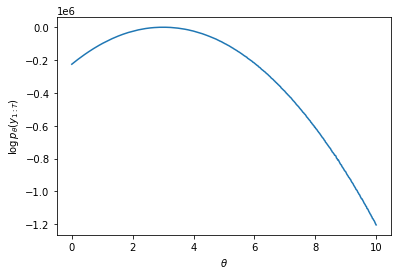

In [5]:
sig = 0.05
sig_prior = 0.01
mu_prior = 5.0

N = 1000

theta_range = np.linspace(0, 10, 500)
log_ml_list = [] # you can use np.append to add elements to this array

for theta in theta_range:
    x_samples = np.random.normal(5, 0.01, N)
    log_ml = log_marginal_likelihood(y, theta, x_samples, sig)
    log_ml_list.append(log_ml)
# uncomment and plot your results (do not remove)

plt.plot(theta_range, log_ml_list)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\log p_\theta(y_{1:T})$')
plt.show()

**(v)** Now you have `log_ml_list` variable that corresponds to marginal likelihood values in `theta_range`. Find the $\theta$ value that gives the maximum value in this list and provide your final estimate of most likely $\theta$. **<span style="color:blue">(5 marks)</span>**

In [6]:
# You code goes here

theta_est = theta_range[log_ml_list.index(max(log_ml_list))]
print(theta_est)

3.006012024048096


## Q2: Posterior sampling (35 marks)

In this question, we will perform posterior sampling for the following model
\begin{align*}
    p(x) &\propto \exp(-x_1^2/10 - x_2^2/10 - 2 (x_2 - x_1^2)^2), \\
    p(y | x) &= \mathcal{N}(y; H x, 0.1)
\end{align*}
where $H = [0, 1]$. In this exercise, we assume that we have observed $y = 2$ and would like to implement a few sampling methods.

Before starting this exercise, please try to understand how the posterior density should look like. The discussion we had during the lecture about Exercise 6.2 (see Panopto if you have not attended) should help you here to understand the posterior density. Note though quantities and various details are **different** here. You should have a good idea about the posterior density before starting this exercise to be able to set the hyperparameters such as the chain-length, proposal noise, and the step-size.

In [7]:
y = np.array([2.0])
sig_lik = 0.1
H = np.array([0, 1])

**(i)** In what follows, you will have to code the log-prior and log-likelihood functions. Do **not** use any library, code the log densities directly. **<span style="color:blue">(5 marks)</span>**

In [8]:
def prior(x): # code banana density for visualisation purposes
    # Define the function
    x1 = x[0]
    x2 = x[1]
    return np.exp(-(x1**2)/10 - (x2**2)/10 - 2*(x2-x1**2)**2)

def log_prior(x): # fill in the arguments
    return np.log(prior(x))

def log_likelihood(y, x, sig_lik): # fill in the arguments
    H = np.array([0, 1])
    Hx = np.dot(H, x)
    log_like = -np.log(np.sqrt(sig_lik *2 * np.pi)) - 1/2 * (y - Hx)**2 / sig_lik**2
    return log_like

# uncomment below and evaluate your prior and likelihood (do not remove)
print(log_prior([0, 1]))
print(log_likelihood(y, np.array([0, 1]), sig_lik))

-2.1
[-49.76764599]


**(ii)** Next, implement **the random walk Metropolis algorithm (RWMH)** for this target. Set an appropriate chain length, proposal variance, and `burnin` value. Plot a scatter-plot with your samples (see the visualisation function below). Use log-densities only. **<span style="color:blue">(10 marks)</span>**

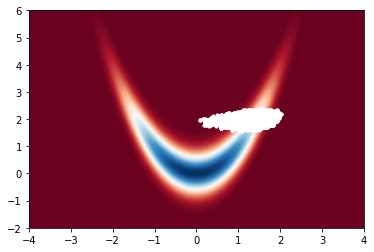

In [9]:
def RWMH(x0, burnin = 1000, chain_length = 100000):
    N = chain_length
    chain = []
    y = 2
    for i in range(N):
        #sample from p(x)
        x = x0 +  0.1*np.random.randn(2)
        #Sample from likelihood:
        acceptance_prob = log_prior(x) + log_likelihood(y, x, sig_lik = 0.1) - log_prior(x0) -log_likelihood(y, x0, sig_lik = 0.1)
        u = np.random.uniform(0, 1)
        if np.log(u) < acceptance_prob:
            x0 = x
        chain.append(x0)
    return chain[burnin:]

x = np.array(RWMH([0, 0])).reshape(-1, 2)

# uncomment and plot your results (do not remove)
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x[:, 0], x[:, 1], s=10 , c='white')
plt.show()

**(iii)** Now implement **Metropolis-adjusted Langevin algorithm**. For this, you will need to code the gradient of the density and use it in the proposal as described in the lecture notes. Set an appropriate chain length, step-size, and `burnin` value. Plot a scatter-plot with your samples (see the visualisation function below). Use log-densities only. **<span style="color:blue">(10 marks)</span>**

In [10]:
def grad_log_prior(x): # fill in the arguments
    x1 = x[0]
    x2 = x[1]
    a = -x1/5 + 8*x1*(x2-x1**2)
    b = -x2/5 - 4*(x2-x1**2)
    return np.array([a, b])

def grad_log_likelihood(y, x, sig_lik=0.1): # fill in the arguments
    x2 = x[1]
    return np.array([0, (y-x2)/sig_lik])

def grad_post(x, y, sig_lik): # fill in the arguments
    return grad_log_likelihood(y, x, sig_lik) + grad_log_prior(x)

def log_MALA_kernel(xprop, x, y, gamma, sig_lik = 0.1): # fill in the arguments
    return - 1/(4 * gamma**2) * np.linalg.norm((xprop - x - gamma * grad_post(x, y, sig_lik))**2)**2

def MALA(x0, gam=0.01, T = 10000, burnin = 100):
    x_mala = np.zeros((T, 2))
    x_mala[0] = x0
    y = 2
    for t in range(1, T):
        #New sample from proposal
        x0 = x_mala[t-1]
        x = x0 + gam * grad_post(x0, y, sig_lik) + 2*gam*np.random.randn(2)
        #sample from y
        acceptance_prob = log_prior(x) + log_likelihood(y, x, sig_lik = 0.1) + log_MALA_kernel(x, x0, y, gam) \
            - log_prior(x_mala[t-1]) - log_likelihood(y, x_mala[t-1], sig_lik = 0.1) - log_MALA_kernel(x0, x, y, gam)
        u = np.random.uniform()
        if np.log(u) < acceptance_prob:
            x_mala[t] = x
        else:
            x_mala[t] = x_mala[t-1]
    return x_mala[burnin:]


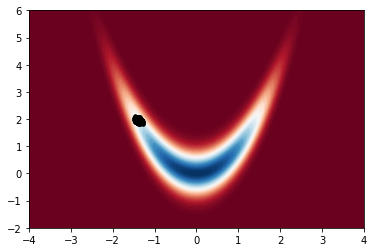

In [11]:
#log_MALA_kernel(np.array([0,0]), np.array([0,0]), 0, gamma=0.01)
x = MALA([0, 0], gam=0.01, T = 10000, burnin = 1000)


x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x[:, 0], x[:, 1], s=10 , c='black')
plt.show()

**(iv)** Next, implement **unadjusted Langevin algorithm**. For this, you will need to code the gradient of the density and use it in the proposal as described in the lecture notes. Set an appropriate chain length, step-size, and `burnin` value. Plot a scatter-plot with your samples (see the visualisation function below). Use log-densities only. **<span style="color:blue">(10 marks)</span>**

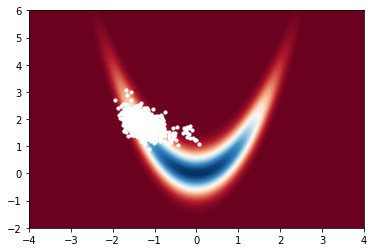

In [12]:
def ULA(x0, gamma, burnin = 100, T = 10000):
    X = np.zeros((T, 2))
    X[0] = x0
    y = 2
    for t in range(1, T):
        X[t] = X[t-1] + gamma * grad_post(X[t-1], y, sig_lik= 0.1) + np.sqrt(2*gamma)*np.random.randn(2)
    return X[burnin:]

x = ULA([0, 0], 0.01, burnin = 100, T = 1000)
# uncomment and plot your results (do not remove)
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x[:, 0], x[:, 1], s=10 , c='white')
plt.show()

## Q3: Gibbs sampling for 2D posterior (25 marks)

In this question, you will first derive a Gibbs sampler by deriving full conditionals. Then we will describe a method to estimate marginal likelihoods using Gibbs output (and you will be asked to implement the said method given the description).

Consider the following probabilistic model
\begin{align*}
p(x_1) &= \mathcal{N}(x_1; \mu_1, \sigma_1^2), \\
p(x_2) &= \mathcal{N}(x_2; \mu_2, \sigma_2^2), \\
p(y | x_1, x_2) &= \mathcal{N}(y; x_1 + x_2, \sigma_y^2),
\end{align*}
where $y$ is a scalar observation and $x_1, x_2$ are latent variables. This is a simple model where we observe a sum of two random variables and want to construct possible values of $x_1, x_2$ given the observation $y$.

**(i)** Derive the Gibbs sampler for this model, by deriving full conditionals $p(x_1 | x_2, y)$ and $p(x_2 | x_1, y)$ (You can use Example 3.2 but note that this case is different). **<span style="color:blue">(10 marks)</span>**

**Solution:** <span style="color:red">**Handwritten**</span>

**(ii)** Let us set $y = 5$, $\mu_1 = 0$, $\mu_2 = 0$, $\sigma_1 = 0.1$, $\sigma_2 = 0.1$, and $\sigma_y = 0.01$.

Implement the Gibbs sampler you derived in Part (i). Set an appropriate chain length and `burnin` value. Plot a scatter plot of your samples (see the visualisation function below). Discuss the result: Why does the posterior look like this? **<span style="color:blue">(15 marks)</span>**

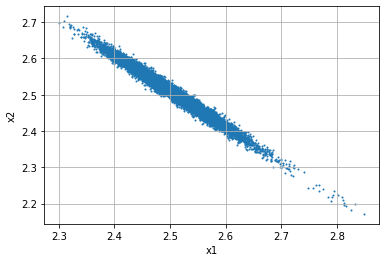

In [19]:
y = 5
mu1 = 0
mu2 = 0
sig1 = 0.1
sig2 = 0.1
sig_y = 0.01
x1 = 0
x2 = 0

n = 10000
burnin = 100
x1_chain = [] #initial value
x2_chain = []
#initial value

for i in range(n):
    x1mu = (y * sig1**2 + mu1 * sig_y**2 - x2 * sig1**2) / (sig1**2 + sig_y**2)
    x1 = np.random.normal(x1mu, np.sqrt((sig1**2 * sig_y**2)/(sig1**2 + sig_y**2)))
    x2mu = (y * sig2**2 + mu2 * sig_y**2 - x1 * sig2**2) / (sig2**2 + sig_y**2)
    x2 = np.random.normal(x2mu, np.sqrt((sig2**2 * sig_y**2)/(sig2**2 + sig_y**2)))
    
    if i==1:
        y = np.random.normal(x1 + x2, sig_y)
        
    x1_chain.append(x1)
    x2_chain.append(x2)
plt.scatter(x1_chain[burnin:], x2_chain[burnin:], s=1)
plt.grid()
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()
